> **Global Cropland Mapping using PSPNet & GEE**
>
> Author: Penghua Liu
>
> Last Update: 2020-02-13

# 查看显卡

In [1]:
!nvidia-smi

Wed Apr  1 05:50:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 环境授权

In [2]:
!earthengine authenticate

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=XrxPa92c_NFGXCP_MJj0cFo9VfECue81OL4tCpwrl4c&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in 

In [3]:
# 授权挂载Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 导入第三方库

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import ee
ee.Initialize()

import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import cv2
from keras import layers
from keras import models
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import ogr
from osgeo import gdal
import osr
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [6]:
tf.__version__

'1.15.2'

# 参数设置

# 新段落

In [0]:
year = 2010
all_grids = ee.FeatureCollection('users/liuph/shape/WorldGrid2p5dSimplev2')
ALL_GRID_IDS = all_grids.reduceColumns(ee.Reducer.toList(), ['ID']).getInfo().get('list') 
ALL_GRID_IDS.sort()
# with open('/content/drive/My Drive/AllGridIDs.txt', 'w') as f:
#   f.write('\n'.join(ALL_GRID_IDS))
  
# # # 定义输入输出文件夹
RAW_IMAGE_DIR = '/content/drive/My Drive/raw_images'
PREDS_DST_DIR = '/content/drive/My Drive/%d_preds' % year
os.makedirs(PREDS_DST_DIR, exist_ok=True)

# # # 预测设置参数
MODEL_VERSION = 'bcegdice_pspnet50_2015lc08srsmote_c1_192x192x7' if year >= 2012 else 'bcegdice_pspnet50_2010lt05srsmote_c1_192x192x7' 
MODEL_CONFIG_PATH = '/content/drive/My Drive/ckpt/pspnet_192x192x7.json'
MODEL_CKPT_PATH = '/content/drive/My Drive/ckpt/%s.h5' % MODEL_VERSION
MODEL_INPUT_SHAPE = (192, 192, 7)
PREDICT_STRIDE = 72
CHANNEL_MINS = np.array([0, 0, 0, 0, 0, -1, -400])
CHANNEL_MAXS = np.array([1, 1, 1, 1, 1, 1, 2000])

In [8]:
# 2100-2298
all_grid_ids =  ALL_GRID_IDS[2100:]

exporting_grid_ids = [task['description'].split('_')[-1] for task in ee.data.getTaskList() if task['state'] == 'RUNNING' or task['state'] == 'READY']
exported_grid_ids = [fn.split('.')[0].split('_')[1] for fn in os.listdir(RAW_IMAGE_DIR)]
predicted_grid_ids = [fn.split('.')[0].split('_')[1] for fn in os.listdir(PREDS_DST_DIR)]
exclude_grid_ids = exporting_grid_ids + exported_grid_ids + predicted_grid_ids
rest_grid_ids = [idx for idx in all_grid_ids if idx not in exclude_grid_ids]
rest_grid_ids.sort()
print('exporting grids (%d):' % len(exporting_grid_ids), exporting_grid_ids)
print('exported grids (%d):' % len(exported_grid_ids), exported_grid_ids)
print('predicted grids (%d):' % len(predicted_grid_ids), predicted_grid_ids)
print('to do ids (%d):' % len(rest_grid_ids), rest_grid_ids)

start_id_idx = 0
end_id_idx = len(rest_grid_ids) - 1
all_grid_ids = rest_grid_ids

exporting grids (0): []
exported grids (5): ['3581', '3582', '3583', '3584', '3585']
predicted grids (92): ['3437', '3438', '3439', '3440', '3441', '3442', '3444', '3443', '3445', '3446', '3447', '3467', '3468', '3469', '3470', '3472', '3471', '3473', '3474', '3475', '3476', '3477', '3478', '3479', '3480', '3481', '3482', '3483', '3484', '3485', '3486', '3487', '3488', '3489', '3490', '3491', '3492', '3493', '3494', '3495', '3496', '3497', '3498', '3499', '3500', '3501', '3502', '3503', '3504', '3505', '3506', '3507', '3508', '3509', '3510', '3511', '3512', '3513', '3514', '3515', '3516', '3517', '3518', '3520', '3519', '3521', '3522', '3523', '3540', '3541', '3542', '3543', '3544', '3546', '3547', '3545', '3548', '3549', '3550', '3568', '3569', '3570', '3571', '3572', '3573', '3574', '3575', '3576', '3577', '3578', '3579', '3580']
to do ids (101): ['3586', '3587', '3588', '3589', '3590', '3591', '3592', '3593', '3594', '3595', '3596', '3597', '3598', '3599', '3600', '3601', '3602', '3

# 功能函数

In [0]:
def log(msg, with_time=True):
  if with_time:
    t = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('{} >>> {}'.format(t, msg))
  else:
    print(' '* 19 + '$ {}'.format(msg))

## 导出2.5°网格影像

In [0]:
def maskLC08SRClouds(image):
  qa = image.select('pixel_qa')
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
  mask2 = image.mask().reduce(ee.Reducer.min())
  return image.updateMask(cloud.Not()).updateMask(mask2)


def get_landsat_sr_image(year, start_month, end_month):
  if year > 2010:
    satSR = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").filter(ee.Filter.calendarRange(year-1, year+1, 'year'))\
                    .filter(ee.Filter.calendarRange(start_month, end_month, 'month'))\
                    .filter(ee.Filter.lt('CLOUD_COVER', 60))\
                    .map(maskLC08SRClouds).median().multiply(0.0001)\
                    .select(['B2', 'B3', 'B4', 'B5', 'B6']).rename(['B', 'G', 'R', 'NIR', 'SWIR1'])
  elif year > 1985:
    satSR = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR").filter(ee.Filter.calendarRange(year-1, year+1, 'year'))\
                    .filter(ee.Filter.calendarRange(start_month, end_month, 'month'))\
                    .filter(ee.Filter.lt('CLOUD_COVER', 60))\
                    .map(maskLC08SRClouds).median().multiply(0.0001)\
                    .select(['B1', 'B2', 'B3', 'B4', 'B5']).rename(['B', 'G', 'R', 'NIR', 'SWIR1'])
  else:
    raise ValueError('year must between [1985, 2019]')
  ndvi = satSR.normalizedDifference(['NIR', 'R']).rename('NDVI')
  dem = ee.Image('USGS/SRTMGL1_003').rename('Dem')
  return satSR.addBands(ndvi).addBands(dem).toFloat()


def export_image_by_grid(sat_image, grid_feature, description, folder, scale):
  geom = grid_feature.geometry()
  task = ee.batch.Export.image.toDrive(image=sat_image, description=description, folder=folder, region=geom, scale=scale, maxPixels=1e13)
  task.start()
  return task


def export_images_by_ids(all_grids, all_grid_ids, export_id_sidx, export_id_nums, sat_image, prefix='2015_'):
  tasks = []
  i = export_id_sidx
  for i in range(export_id_sidx, export_id_sidx + export_id_nums):
    # log('Export Grid: {}/{}, grid index={}'.format(i, len(all_grid_ids), all_grid_ids[i]))
    feature = ee.Feature(all_grids.filterMetadata('ID', 'equals', all_grid_ids[i]).first())
    # 如果该网格已经预测了，就不再导出了
    if os.path.exists(PREDS_DST_DIR + '/' + prefix + str(all_grid_ids[i]) + '.tif'):
      continue
    task = export_image_by_grid(sat_image, feature, prefix + str(all_grid_ids[i]), 'raw_images', 30)
    tasks.append(task)
  return tasks


## GDAL 读写 GeoTIFF 图像

In [0]:
def get_array_from_dataset(ds, left_col, top_row, cols, rows):
    """ Extract data array from raster dataset given the up-left point and array shape

    # Args:
        ds (gdal.Dataset): Raster dataset.
        left_col (int): the column index of the left boundary.
        top_row (int): the  row index of the top boundary.
        cols (int): the columns of data array to extract.
        rows (int): the rows of the data array to extract.

    # Returns:
        np.ndarray (3-d)
    """
    n_cols = ds.RasterXSize
    n_rows = ds.RasterYSize
    cols = min(n_cols - left_col, cols)
    rows = min(n_rows - top_row, rows)
    data = ds.ReadAsArray(left_col, top_row, cols, rows)
    data = np.transpose(data, (1, 2, 0))
    data = np.where(np.isnan(data), 0, data)
    return data

def save_tif_image(data, tif_path, data_type=gdal.GDT_Byte,
                   geo_transform=(0, 1, 0, 0, 0, -1),
                   projection=None, no_data=None):
    """ save data to tiff file.

    # Args:
        data (np.ndarray): the data array to save.
        tif_path (string): the path to save tiff tile.
        data_type (gdalconst): the data type to save.
        geo_transform: the geo-transform parameters, with 6 parameters indicating the
            (up_x, x_size, 0, up_y, 0, y_size).
        projection (string): the spatial coordinate system.
        no_data (int/float): value that will set to no-data.

    """
    assert isinstance(data, np.ndarray), "the data array must be 'np.ndarray'."
    if data.ndim == 2:
        data = np.expand_dims(data, -1)
    assert data.ndim == 3, "the data array must have 2 or 3 dimensions."

    bands = data.shape[-1]
    rows, cols = data.shape[:2]
    data_type = gdal.GDT_Byte if data_type is None else data_type

    driver = gdal.GetDriverByName("GTiff")
    if os.path.exists(tif_path):
        os.remove(tif_path)

    out_raster = driver.Create(tif_path, cols, rows, bands, data_type, ['COMPRESS=LZW', 'TILED=YES'])
    out_raster.SetGeoTransform(geo_transform)
    if projection is not None:
        out_raster_srs = osr.SpatialReference()
        out_raster_srs.ImportFromWkt(projection)
        out_raster.SetProjection(out_raster_srs.ExportToWkt())

    for band_i in range(bands):
        out_band = out_raster.GetRasterBand(band_i + 1)
        if no_data is not None:
            out_band.SetNoDataValue(no_data)
        out_band.WriteArray(data[:, :, band_i])
        out_band.FlushCache()

## 预测一景影像

In [0]:
def predict_per_image(model, ds, patch_height=128, patch_width=128, n_class=1,
                      stride=64, to_prob=True, channel_min=None, channel_max=None):
    """ predict for a tiff image

    # Args:
        model (keras.Model): keras model instance.
        ds (gdal.Dataset): the raster dataset.
        patch_height (int): the height of image patch per prediction.
        patch_width (int): the width of image patch.
        n_class (int): the predicted class number.
        stride (int): prediction overlap size.
        to_prob (bool): whether to save probability.
        channel_mean (np.ndarray): the mean of each channel.
        channel_std (np.ndarray): the std of each channel.
    """
    image_height, image_width, image_channel = ds.RasterYSize, ds.RasterXSize, ds.RasterCount
    stride = patch_width // 4 if stride is None else stride
    padding_height = int(np.ceil((image_height - patch_height) / stride) * stride + patch_height)
    padding_width = int(np.ceil((image_width - patch_width) / stride) * stride + patch_width)

    # define probabilities and count matrix
    mask_probas = np.zeros((padding_height, padding_width, n_class), dtype=np.float16)
    mask_counts = np.zeros_like(mask_probas, dtype=np.uint8)

    # iterate from top to bottom, left to right to predict each row
    for i in tqdm_notebook(range((padding_height - patch_height) // stride + 1)):
        _padding_images = []
        for j in range((padding_width - patch_width) // stride + 1):
            _padding_image = np.zeros((patch_height, patch_width, image_channel))
            _image = get_array_from_dataset(ds, j * stride, i * stride, patch_width, patch_height)
            _image = (_image - channel_min) / (channel_max - channel_min)
            _padding_image[:_image.shape[0], :_image.shape[1]] = _image
            _padding_images.append(_padding_image)

        preds = model.predict(np.array(_padding_images), verbose=2)
        for j in range((padding_width - patch_width) // stride + 1):
            mask_probas[i * stride:i * stride + patch_height, j * stride:j * stride + patch_width] += preds[j]
            mask_counts[i * stride:i * stride + patch_height, j * stride:j * stride + patch_width] += 1
    # average probability
    mask_probas[:image_height, :image_width] = mask_probas[:image_height, :image_width] \
                                               / mask_counts[:image_height, :image_width]
    if to_prob:
        return mask_probas[:image_height, :image_width]
    else:
        return np.array(mask_probas[:image_height, :image_width] >= 0.5, dtype=np.uint8)

In [0]:
# !earthengine --no-use_cloud_api task info X5II3DAZAJB2QV2U3TMPTF7D  # State

# tasks = [task for task in ee.data.getTaskList() if task['state'] == 'COMPLETED']
# for task in tasks:
#   print(task['id'])

# 主函数

2020-04-01 05:52:38 >>> Total grid count: 101
2020-04-01 05:52:38 >>> Build model and load weights...

















2020-04-01 05:52:56 >>> GRID ID INDEX=0
                   $ all export tasks: []
                   $ current images: ['3581', '3582', '3583', '3584', '3585']
                   $ current prediction count: 92
2020-04-01 05:52:56 >>> Predict image (id= 3581)... 


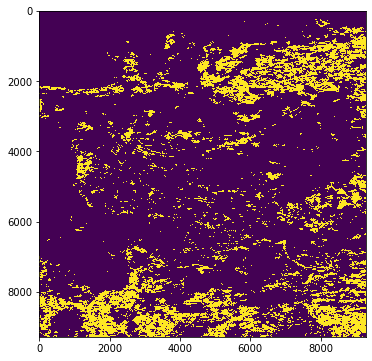

2020-04-01 05:58:22 >>> save tif file `2010_3581.tif`...

2020-04-01 05:58:22 >>> GRID ID INDEX=0
                   $ all export tasks: []
                   $ current images: ['3581', '3582', '3583', '3584', '3585']
                   $ current prediction count: 93
2020-04-01 05:58:25 >>> Remove grid image (id=3581)
                   $ Start a new export task (id_index=0, id=3586)
2020-04-01 05:58:27 >>> GRID ID INDEX=1
2020-04-01 05:58:27 >>> Predict image (id= 3582)... 


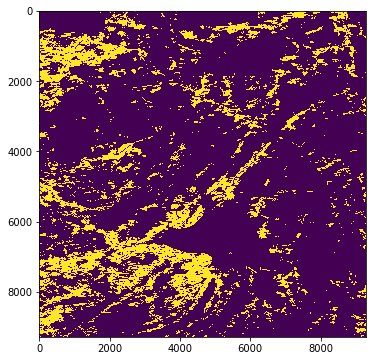

2020-04-01 06:03:51 >>> save tif file `2010_3582.tif`...

2020-04-01 06:03:52 >>> GRID ID INDEX=1
                   $ all export tasks: ['2010_3586']
                   $ current images: ['3582', '3583', '3584', '3585']
                   $ current prediction count: 94
2020-04-01 06:03:54 >>> Remove grid image (id=3582)
                   $ Start a new export task (id_index=1, id=3587)
2020-04-01 06:03:55 >>> GRID ID INDEX=2
2020-04-01 06:03:55 >>> Predict image (id= 3583)... 


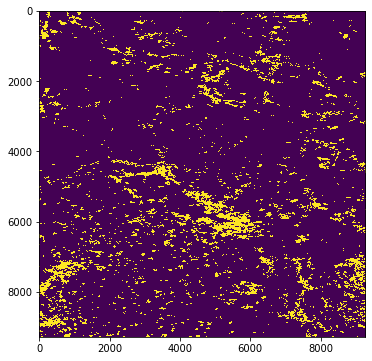

2020-04-01 06:09:21 >>> save tif file `2010_3583.tif`...

2020-04-01 06:09:21 >>> GRID ID INDEX=2
                   $ all export tasks: ['2010_3587']
                   $ current images: ['3583', '3584', '3585', '3586']
                   $ current prediction count: 95
2020-04-01 06:09:23 >>> Remove grid image (id=3583)
                   $ Start a new export task (id_index=2, id=3588)
2020-04-01 06:09:25 >>> GRID ID INDEX=3
2020-04-01 06:09:25 >>> Predict image (id= 3584)... 


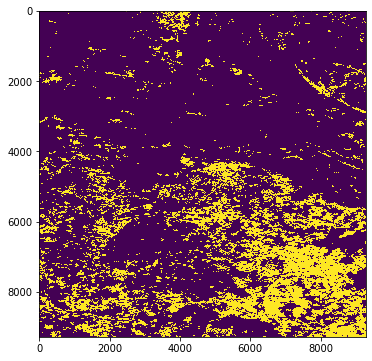

2020-04-01 06:14:50 >>> save tif file `2010_3584.tif`...

2020-04-01 06:14:50 >>> GRID ID INDEX=3
                   $ all export tasks: ['2010_3588']
                   $ current images: ['3584', '3585', '3586']
                   $ current prediction count: 96
                   $ Export image: start id index = 3, number of grids=1
2020-04-01 06:14:53 >>> GRID ID INDEX=4
2020-04-01 06:14:53 >>> Remove grid image (id=3584)
                   $ Start a new export task (id_index=4, id=3590)
2020-04-01 06:14:55 >>> GRID ID INDEX=5
2020-04-01 06:14:55 >>> Predict image (id= 3585)... 


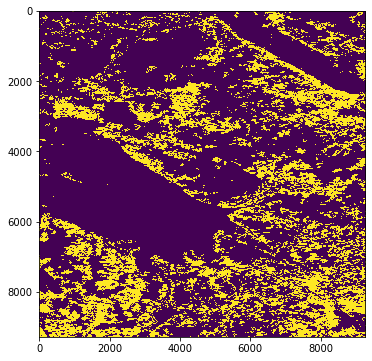

2020-04-01 06:20:17 >>> save tif file `2010_3585.tif`...

2020-04-01 06:20:17 >>> GRID ID INDEX=5
                   $ all export tasks: ['2010_3590', '2010_3589', '2010_3588']
                   $ current images: ['3585', '3586', '3587']
                   $ current prediction count: 97
2020-04-01 06:20:19 >>> Remove grid image (id=3585)
                   $ Start a new export task (id_index=5, id=3591)
2020-04-01 06:20:21 >>> GRID ID INDEX=6
2020-04-01 06:20:21 >>> Predict image (id= 3586)... 


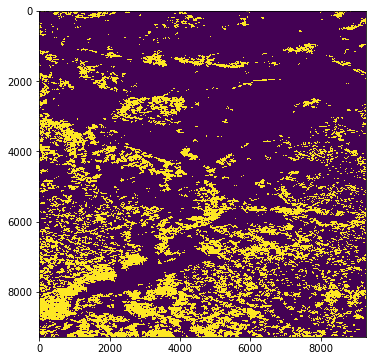

2020-04-01 06:25:45 >>> save tif file `2010_3586.tif`...

2020-04-01 06:25:46 >>> GRID ID INDEX=6
                   $ all export tasks: ['2010_3591', '2010_3590', '2010_3589']
                   $ current images: ['3586', '3587', '3588']
                   $ current prediction count: 98
2020-04-01 06:25:48 >>> Remove grid image (id=3586)
                   $ Start a new export task (id_index=6, id=3592)
2020-04-01 06:25:50 >>> GRID ID INDEX=7
2020-04-01 06:25:50 >>> Predict image (id= 3587)... 


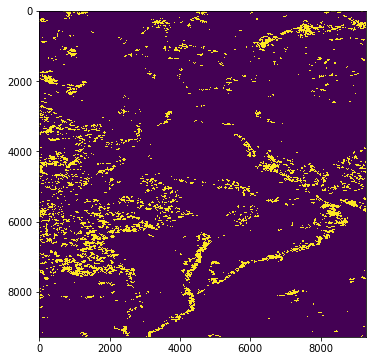

2020-04-01 06:31:18 >>> save tif file `2010_3587.tif`...

2020-04-01 06:31:18 >>> GRID ID INDEX=7
                   $ all export tasks: ['2010_3592', '2010_3591', '2010_3590', '2010_3589']
                   $ current images: ['3587', '3588']
                   $ current prediction count: 99
2020-04-01 06:31:20 >>> Remove grid image (id=3587)
                   $ Start a new export task (id_index=7, id=3593)
2020-04-01 06:31:21 >>> GRID ID INDEX=8
2020-04-01 06:31:21 >>> Predict image (id= 3588)... 


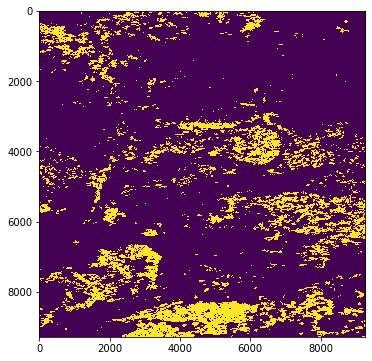

2020-04-01 06:36:49 >>> save tif file `2010_3588.tif`...

2020-04-01 06:36:49 >>> GRID ID INDEX=8
                   $ all export tasks: ['2010_3593', '2010_3592', '2010_3591', '2010_3590', '2010_3589']
                   $ current images: ['3588']
                   $ current prediction count: 100
2020-04-01 06:36:52 >>> Remove grid image (id=3588)
                   $ Start a new export task (id_index=8, id=3594)
2020-04-01 06:36:54 >>> GRID ID INDEX=9
                   $ wating for 3 min...

2020-04-01 06:39:54 >>> GRID ID INDEX=9
                   $ all export tasks: ['2010_3594', '2010_3593', '2010_3592', '2010_3591', '2010_3590', '2010_3589']
                   $ current images: []
                   $ current prediction count: 100
                   $ wating for 3 mins...

2020-04-01 06:42:55 >>> GRID ID INDEX=9
                   $ all export tasks: ['2010_3594', '2010_3593', '2010_3592', '2010_3591', '2010_3589']
                   $ current images: ['3590']
                

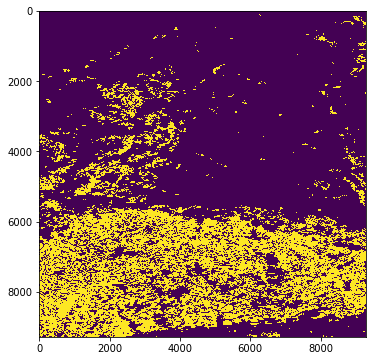

2020-04-01 06:48:21 >>> save tif file `2010_3590.tif`...

2020-04-01 06:48:21 >>> GRID ID INDEX=9
                   $ all export tasks: ['2010_3594', '2010_3593', '2010_3592', '2010_3591']
                   $ current images: ['3589', '3590']
                   $ current prediction count: 101
2020-04-01 06:48:23 >>> Remove grid image (id=3590)
                   $ Start a new export task (id_index=9, id=3595)
2020-04-01 06:48:24 >>> GRID ID INDEX=10
2020-04-01 06:48:24 >>> Predict image (id= 3589)... 


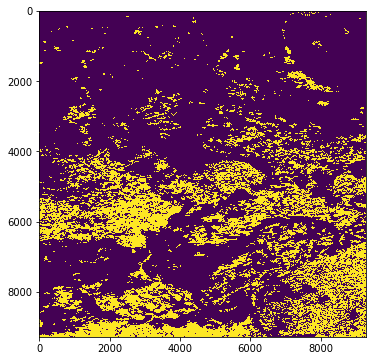

2020-04-01 06:53:51 >>> save tif file `2010_3589.tif`...

2020-04-01 06:53:51 >>> GRID ID INDEX=10
                   $ all export tasks: ['2010_3595', '2010_3594', '2010_3593', '2010_3591']
                   $ current images: ['3589', '3592']
                   $ current prediction count: 102
2020-04-01 06:53:53 >>> Remove grid image (id=3589)
                   $ Start a new export task (id_index=10, id=3596)
2020-04-01 06:53:54 >>> GRID ID INDEX=11
2020-04-01 06:53:54 >>> Predict image (id= 3592)... 


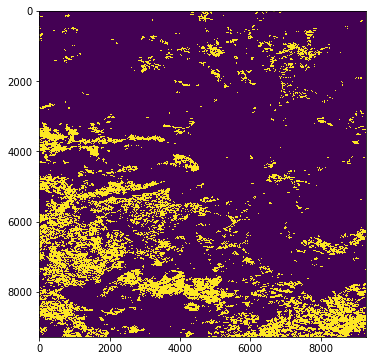

2020-04-01 06:59:20 >>> save tif file `2010_3592.tif`...

2020-04-01 06:59:20 >>> GRID ID INDEX=11
                   $ all export tasks: ['2010_3596', '2010_3595', '2010_3594', '2010_3593']
                   $ current images: ['3591', '3592']
                   $ current prediction count: 103
2020-04-01 06:59:23 >>> Remove grid image (id=3592)
                   $ Start a new export task (id_index=11, id=3597)
2020-04-01 06:59:25 >>> GRID ID INDEX=12
2020-04-01 06:59:25 >>> Predict image (id= 3591)... 


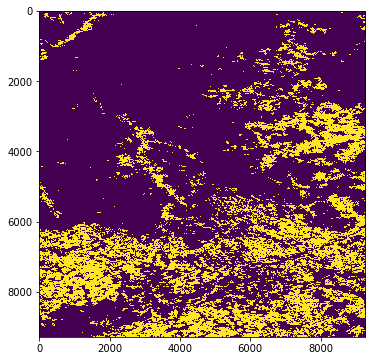

2020-04-01 07:04:49 >>> save tif file `2010_3591.tif`...

2020-04-01 07:04:50 >>> GRID ID INDEX=12
                   $ all export tasks: ['2010_3597', '2010_3596', '2010_3595', '2010_3594', '2010_3593']
                   $ current images: ['3591']
                   $ current prediction count: 104
2020-04-01 07:04:52 >>> Remove grid image (id=3591)
                   $ Start a new export task (id_index=12, id=3598)
2020-04-01 07:04:54 >>> GRID ID INDEX=13
                   $ wating for 3 min...

2020-04-01 07:07:54 >>> GRID ID INDEX=13
                   $ all export tasks: ['2010_3598', '2010_3597', '2010_3596', '2010_3595']
                   $ current images: ['3593', '3594']
                   $ current prediction count: 104
2020-04-01 07:07:55 >>> Predict image (id= 3593)... 


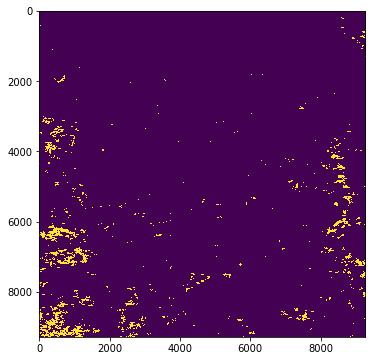

2020-04-01 07:13:23 >>> save tif file `2010_3593.tif`...

2020-04-01 07:13:23 >>> GRID ID INDEX=13
                   $ all export tasks: ['2010_3598', '2010_3597', '2010_3596', '2010_3595']
                   $ current images: ['3593', '3594']
                   $ current prediction count: 105
2020-04-01 07:13:26 >>> Remove grid image (id=3593)
                   $ Start a new export task (id_index=13, id=3599)
2020-04-01 07:13:28 >>> GRID ID INDEX=14
2020-04-01 07:13:28 >>> Predict image (id= 3594)... 


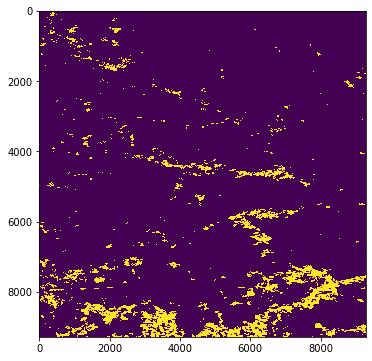

2020-04-01 07:18:56 >>> save tif file `2010_3594.tif`...

2020-04-01 07:18:56 >>> GRID ID INDEX=14
                   $ all export tasks: ['2010_3599', '2010_3598', '2010_3597', '2010_3596']
                   $ current images: ['3594', '3595']
                   $ current prediction count: 106
2020-04-01 07:18:59 >>> Remove grid image (id=3594)
                   $ Start a new export task (id_index=14, id=3600)
2020-04-01 07:18:59 >>> GRID ID INDEX=15
2020-04-01 07:18:59 >>> Predict image (id= 3595)... 


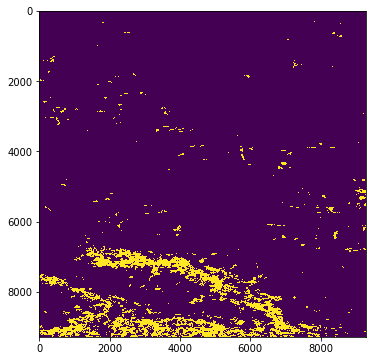

2020-04-01 07:24:31 >>> save tif file `2010_3595.tif`...

2020-04-01 07:24:31 >>> GRID ID INDEX=15
                   $ all export tasks: ['2010_3600', '2010_3599', '2010_3598', '2010_3597', '2010_3596']
                   $ current images: ['3595']
                   $ current prediction count: 107
2020-04-01 07:24:33 >>> Remove grid image (id=3595)
                   $ Start a new export task (id_index=15, id=3601)
2020-04-01 07:24:35 >>> GRID ID INDEX=16
                   $ wating for 3 min...

2020-04-01 07:27:35 >>> GRID ID INDEX=16
                   $ all export tasks: ['2010_3601', '2010_3600', '2010_3599', '2010_3598', '2010_3597']
                   $ current images: []
                   $ current prediction count: 107
                   $ wating for 3 mins...

2020-04-01 07:30:36 >>> GRID ID INDEX=16
                   $ all export tasks: ['2010_3601', '2010_3600', '2010_3599', '2010_3598', '2010_3597']
                   $ current images: ['3596']
                   $ cur

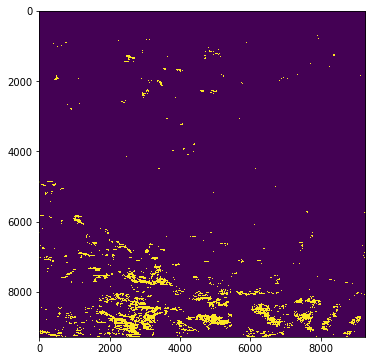

2020-04-01 07:36:06 >>> save tif file `2010_3596.tif`...

2020-04-01 07:36:07 >>> GRID ID INDEX=16
                   $ all export tasks: ['2010_3601', '2010_3600', '2010_3599']
                   $ current images: ['3596', '3597', '3598']
                   $ current prediction count: 108
2020-04-01 07:36:09 >>> Remove grid image (id=3596)
                   $ Start a new export task (id_index=16, id=3602)
2020-04-01 07:36:10 >>> GRID ID INDEX=17
2020-04-01 07:36:10 >>> Predict image (id= 3597)... 


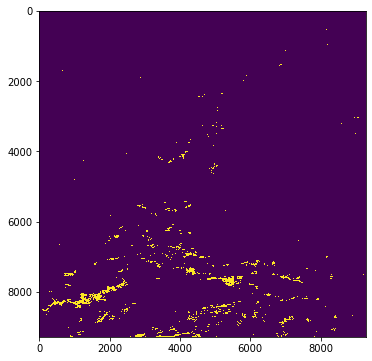

2020-04-01 07:41:41 >>> save tif file `2010_3597.tif`...

2020-04-01 07:41:41 >>> GRID ID INDEX=17
                   $ all export tasks: ['2010_3602', '2010_3601', '2010_3600', '2010_3599']
                   $ current images: ['3597', '3598']
                   $ current prediction count: 109
2020-04-01 07:41:43 >>> Remove grid image (id=3597)
                   $ Start a new export task (id_index=17, id=3603)
2020-04-01 07:41:45 >>> GRID ID INDEX=18
2020-04-01 07:41:45 >>> Predict image (id= 3598)... 


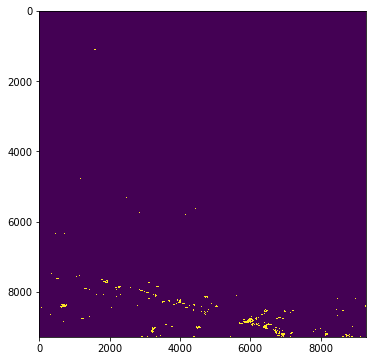

2020-04-01 07:47:21 >>> save tif file `2010_3598.tif`...

2020-04-01 07:47:21 >>> GRID ID INDEX=18
                   $ all export tasks: ['2010_3603', '2010_3602', '2010_3601']
                   $ current images: ['3598', '3599', '3600']
                   $ current prediction count: 110
2020-04-01 07:47:23 >>> Remove grid image (id=3598)
                   $ Start a new export task (id_index=18, id=3604)
2020-04-01 07:47:25 >>> GRID ID INDEX=19
2020-04-01 07:47:25 >>> Predict image (id= 3599)... 


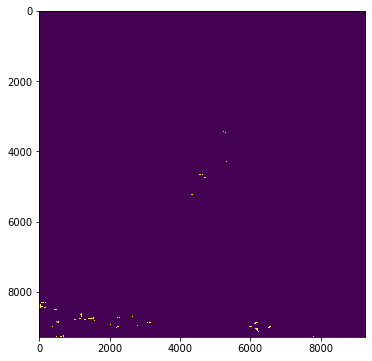

2020-04-01 07:53:01 >>> save tif file `2010_3599.tif`...

2020-04-01 07:53:01 >>> GRID ID INDEX=19
                   $ all export tasks: ['2010_3604', '2010_3603', '2010_3602']
                   $ current images: ['3599', '3600', '3601']
                   $ current prediction count: 111
2020-04-01 07:53:03 >>> Remove grid image (id=3599)
                   $ Start a new export task (id_index=19, id=3605)
2020-04-01 07:53:04 >>> GRID ID INDEX=20
2020-04-01 07:53:04 >>> Predict image (id= 3600)... 


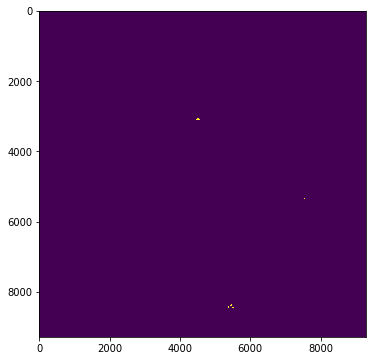

2020-04-01 07:58:39 >>> save tif file `2010_3600.tif`...

2020-04-01 07:58:40 >>> GRID ID INDEX=20
                   $ all export tasks: ['2010_3605', '2010_3604', '2010_3603', '2010_3602']
                   $ current images: ['3600', '3601']
                   $ current prediction count: 112
2020-04-01 07:58:42 >>> Remove grid image (id=3600)
                   $ Start a new export task (id_index=20, id=3606)
2020-04-01 07:58:44 >>> GRID ID INDEX=21
2020-04-01 07:58:44 >>> Predict image (id= 3601)... 


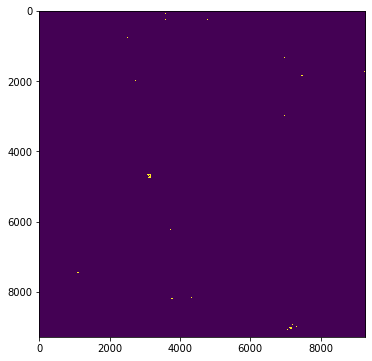

2020-04-01 08:04:20 >>> save tif file `2010_3601.tif`...

2020-04-01 08:04:20 >>> GRID ID INDEX=21
                   $ all export tasks: ['2010_3606', '2010_3605', '2010_3604', '2010_3603', '2010_3602']
                   $ current images: ['3601']
                   $ current prediction count: 113
2020-04-01 08:04:23 >>> Remove grid image (id=3601)
                   $ Start a new export task (id_index=21, id=3607)
2020-04-01 08:04:24 >>> GRID ID INDEX=22
                   $ wating for 3 min...

2020-04-01 08:07:24 >>> GRID ID INDEX=22
                   $ all export tasks: ['2010_3607', '2010_3606', '2010_3605', '2010_3604', '2010_3603']
                   $ current images: ['3602']
                   $ current prediction count: 113
2020-04-01 08:07:26 >>> Predict image (id= 3602)... 


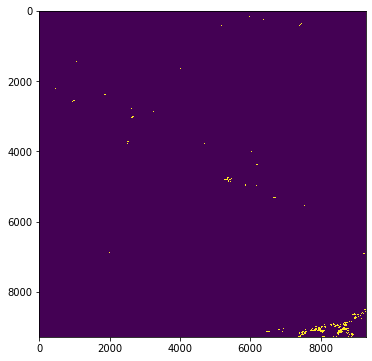

2020-04-01 08:13:01 >>> save tif file `2010_3602.tif`...

2020-04-01 08:13:02 >>> GRID ID INDEX=22
                   $ all export tasks: ['2010_3607', '2010_3606', '2010_3605', '2010_3604', '2010_3603']
                   $ current images: ['3602']
                   $ current prediction count: 114
2020-04-01 08:13:04 >>> Remove grid image (id=3602)
                   $ Start a new export task (id_index=22, id=3608)
2020-04-01 08:13:06 >>> GRID ID INDEX=23
                   $ wating for 3 min...

2020-04-01 08:16:06 >>> GRID ID INDEX=23
                   $ all export tasks: ['2010_3608', '2010_3607', '2010_3606', '2010_3605', '2010_3604']
                   $ current images: ['3603']
                   $ current prediction count: 114
2020-04-01 08:16:07 >>> Predict image (id= 3603)... 


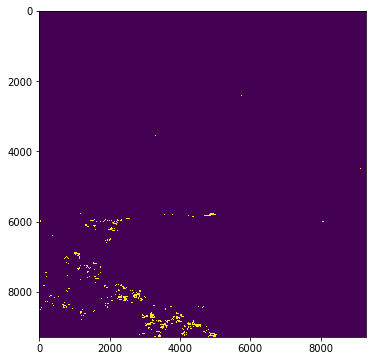

2020-04-01 08:21:43 >>> save tif file `2010_3603.tif`...

2020-04-01 08:21:43 >>> GRID ID INDEX=23
                   $ all export tasks: ['2010_3608', '2010_3607', '2010_3606', '2010_3605']
                   $ current images: ['3603']
                   $ current prediction count: 115
2020-04-01 08:21:46 >>> Remove grid image (id=3603)
                   $ Start a new export task (id_index=23, id=3609)
2020-04-01 08:21:48 >>> GRID ID INDEX=24
                   $ wating for 3 min...

2020-04-01 08:24:48 >>> GRID ID INDEX=24
                   $ all export tasks: ['2010_3609', '2010_3608', '2010_3607', '2010_3606', '2010_3605']
                   $ current images: ['3604']
                   $ current prediction count: 115
2020-04-01 08:24:49 >>> Predict image (id= 3604)... 


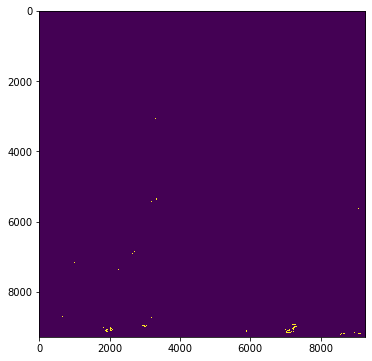

2020-04-01 08:30:49 >>> save tif file `2010_3604.tif`...

2020-04-01 08:30:49 >>> GRID ID INDEX=24
                   $ all export tasks: ['2010_3609', '2010_3608', '2010_3607', '2010_3606', '2010_3605']
                   $ current images: ['3604']
                   $ current prediction count: 116
2020-04-01 08:30:53 >>> Remove grid image (id=3604)
                   $ Start a new export task (id_index=24, id=3610)
2020-04-01 08:30:54 >>> GRID ID INDEX=25
                   $ wating for 3 min...

2020-04-01 08:33:54 >>> GRID ID INDEX=25
                   $ all export tasks: ['2010_3610', '2010_3609', '2010_3608', '2010_3607', '2010_3606']
                   $ current images: ['3605']
                   $ current prediction count: 116
2020-04-01 08:33:55 >>> Predict image (id= 3605)... 


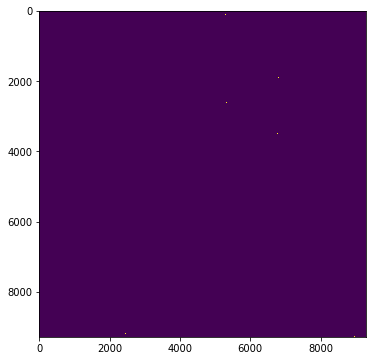

2020-04-01 08:39:30 >>> save tif file `2010_3605.tif`...

2020-04-01 08:39:31 >>> GRID ID INDEX=25
                   $ all export tasks: ['2010_3610', '2010_3609', '2010_3608', '2010_3607']
                   $ current images: ['3605']
                   $ current prediction count: 117
2020-04-01 08:39:33 >>> Remove grid image (id=3605)
                   $ Start a new export task (id_index=25, id=3611)
2020-04-01 08:39:35 >>> GRID ID INDEX=26
                   $ wating for 3 min...

2020-04-01 08:42:35 >>> GRID ID INDEX=26
                   $ all export tasks: ['2010_3611', '2010_3610', '2010_3609', '2010_3608', '2010_3607']
                   $ current images: ['3606']
                   $ current prediction count: 117
2020-04-01 08:42:37 >>> Predict image (id= 3606)... 


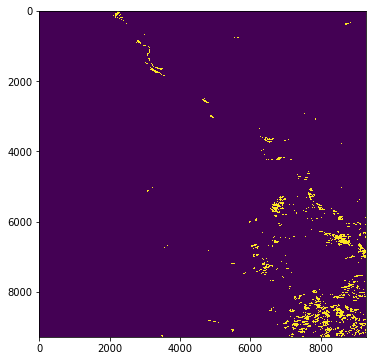

2020-04-01 08:48:07 >>> save tif file `2010_3606.tif`...

2020-04-01 08:48:07 >>> GRID ID INDEX=26
                   $ all export tasks: ['2010_3611', '2010_3610', '2010_3609', '2010_3608']
                   $ current images: ['3606', '3607']
                   $ current prediction count: 118
2020-04-01 08:48:10 >>> Remove grid image (id=3606)
                   $ Start a new export task (id_index=26, id=3612)
2020-04-01 08:48:12 >>> GRID ID INDEX=27
2020-04-01 08:48:12 >>> Predict image (id= 3607)... 


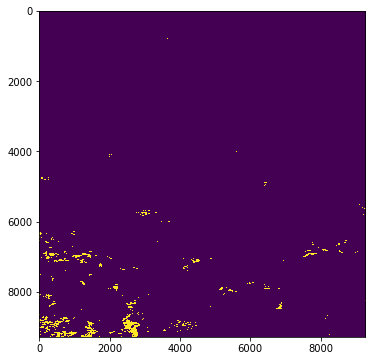

2020-04-01 08:53:43 >>> save tif file `2010_3607.tif`...

2020-04-01 08:53:43 >>> GRID ID INDEX=27
                   $ all export tasks: ['2010_3612', '2010_3611', '2010_3610', '2010_3609', '2010_3608']
                   $ current images: ['3607']
                   $ current prediction count: 119
2020-04-01 08:53:47 >>> Remove grid image (id=3607)
                   $ Start a new export task (id_index=27, id=3613)
2020-04-01 08:53:48 >>> GRID ID INDEX=28
                   $ wating for 3 min...

2020-04-01 08:56:48 >>> GRID ID INDEX=28
                   $ all export tasks: ['2010_3613', '2010_3612', '2010_3611', '2010_3610', '2010_3609']
                   $ current images: ['3608']
                   $ current prediction count: 119
2020-04-01 08:56:49 >>> Predict image (id= 3608)... 


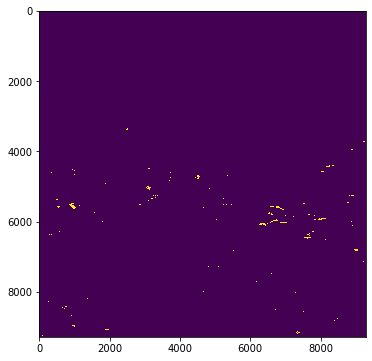

2020-04-01 09:02:19 >>> save tif file `2010_3608.tif`...

2020-04-01 09:02:20 >>> GRID ID INDEX=28
                   $ all export tasks: ['2010_3613', '2010_3612', '2010_3611', '2010_3610', '2010_3609']
                   $ current images: ['3608']
                   $ current prediction count: 120
2020-04-01 09:02:22 >>> Remove grid image (id=3608)
                   $ Start a new export task (id_index=28, id=3614)
2020-04-01 09:02:24 >>> GRID ID INDEX=29
                   $ wating for 3 min...

2020-04-01 09:05:24 >>> GRID ID INDEX=29
                   $ all export tasks: ['2010_3614', '2010_3613', '2010_3612', '2010_3611', '2010_3610', '2010_3609']
                   $ current images: []
                   $ current prediction count: 120
                   $ wating for 3 mins...

2020-04-01 09:08:26 >>> GRID ID INDEX=29
                   $ all export tasks: ['2010_3614', '2010_3613', '2010_3612', '2010_3611', '2010_3610', '2010_3609']
                   $ current images: []
    

In [0]:
if __name__ == '__main__':
  sat_image = get_landsat_sr_image(year, 1, 12)
  log('Total grid count: %d' % len(all_grid_ids))
  
  # 构建模型，导入权重
  # K.clear_session()
  log('Build model and load weights...\n\n')
  with open(MODEL_CONFIG_PATH, 'r') as f:
    model_json = f.read()
  model = models.model_from_json(model_json, custom_objects={'tf': tf})
  model.load_weights(MODEL_CKPT_PATH)

  # 获取正在运行的任务，以及现有的已导出图像
  all_export_tasks = [task for task in ee.data.getTaskList() if task['state'] == 'RUNNING' or task['state'] == 'READY']
  current_image_ids =  [fn.replace('.tif', '').split('_')[-1] for fn in os.listdir(RAW_IMAGE_DIR)]

  while True:
    print()
    log('GRID ID INDEX=%d' % start_id_idx)

    # 获取正在运行的导出任务，移除已完成的导出任务
    all_export_tasks = [task for task in ee.data.getTaskList() if task['state'] == 'RUNNING' or task['state'] == 'READY']
    log('all export tasks: {}'.format([task['description'] for task in all_export_tasks]), with_time=False)

    # 获取RAW_IMAGE_DIR中的图像和正在导出的图像数目
    current_image_ids = [fn.replace('.tif', '').split('_')[-1] for fn in os.listdir(RAW_IMAGE_DIR)]
    current_image_ids.sort()
    current_preds_ids = [fn.replace('.tif', '').split('_')[-1] for fn in os.listdir(PREDS_DST_DIR)]
    log('current images: {}'.format(current_image_ids), with_time=False)
    log('current prediction count: {}'.format(len(current_preds_ids)), with_time=False)
    # 待预测的图像ID
    ids_to_predict = [idx for idx in current_image_ids if idx not in current_preds_ids]

    # # # 退出的条件：所有id已经导出 && 当前输入路径中没有文件了 && 没有正在导出的任务
    if start_id_idx > end_id_idx and len(current_image_ids) == 0 and len(all_export_tasks) == 0:
      break

    # 如果存量不够（少于5景），则导出足够多；如果id已经超过了end id，则不再继续导出了
    if len(current_image_ids) + len(all_export_tasks) < 5:
      if start_id_idx <= end_id_idx:
        export_count = min(5-len(current_image_ids)-len(all_export_tasks), end_id_idx - start_id_idx + 1)
        # print(export_count)
        tasks = export_images_by_ids(all_grids, all_grid_ids, start_id_idx, export_count, sat_image, prefix='%d_' % year)
        all_export_tasks = all_export_tasks + tasks
        log('Export image: start id index = {}, number of grids={}'.format(start_id_idx, len(tasks)), with_time=False)
        start_id_idx += len(tasks)
        log('GRID ID INDEX={}'.format(start_id_idx))

    # 1. 如果RAW_IMAGE_DIR中根本没有图像，则返回导出图像(如果有正在导出的任务，则等待3分钟)
    if len(current_image_ids) == 0:
      if len(all_export_tasks) > 0:
        log('wating for 3 mins...', with_time=False)
        time.sleep(180)
      continue

    # 2. RAW_IMAGE_DIR中有图像，(1)图像被预测过，则删除；
    for image_id in current_image_ids:
      if image_id in current_preds_ids:
        # 删除一张image，并启动一个导出程序
        log('Remove grid image (id={})'.format(image_id))
        os.remove('{}/{}_{}.tif'.format(RAW_IMAGE_DIR, year, image_id))
        if start_id_idx > end_id_idx:
          continue
        log('Start a new export task (id_index={}, id={})'.format(start_id_idx, all_grid_ids[start_id_idx]), with_time=False)
        tasks = export_images_by_ids(all_grids, all_grid_ids, start_id_idx, 1, sat_image, prefix='%d_' % year)
        all_export_tasks = all_export_tasks + tasks
        start_id_idx += 1
        log('GRID ID INDEX={}'.format(start_id_idx))

    # 2. RAW_IMAGE_DIR中有图像, (2)图像没有被预测过，则预测
    # 如果没有合适需要预测的id，则返回循环开始部分导出影像(如果有正在导出的任务，则等待3分钟)
    if len(ids_to_predict) == 0:
      if len(all_export_tasks) > 0:
        log('wating for 3 min...', with_time=False)
        time.sleep(180)
      continue
    else:
      # predict -> plot -> save
      log('Predict image (id= {})... '.format(ids_to_predict[0]))
      tif_filename = '{}_{}.tif'.format(year, ids_to_predict[0])
      ds = gdal.Open(os.path.join(RAW_IMAGE_DIR, tif_filename), gdal.GA_ReadOnly)
      res = predict_per_image(model, ds, MODEL_INPUT_SHAPE[0], MODEL_INPUT_SHAPE[1], n_class=1, stride=PREDICT_STRIDE, 
                               to_prob=False, channel_min=CHANNEL_MINS, channel_max=CHANNEL_MAXS)
      
      plt.figure(figsize=(6, 6))
      plt.imshow(res[ :, :, 0], interpolation='none')
      plt.show()

      log('save tif file `%s`...' % tif_filename)
      save_tif_image(data=res, tif_path=os.path.join(PREDS_DST_DIR, tif_filename),
                       data_type=gdal.GDT_Byte, geo_transform=ds.GetGeoTransform(), projection=ds.GetProjection())
      del ds



# 新段落